# Practice Lecture 9: Training Linear Models
Based on Chapter 4 from Aurelien Geron's book, Hands-on Machine Learning with Scikit-Learn Keras & Tensorflow.\
Original code examples from book in github [here](https://github.com/ageron/handson-ml2)

<table align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/dtrad/geoml_course/blob/master/Practice9.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
</table>

In [1]:
import sklearn
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
#get_ipython().run_line_magic('matplotlib', 'inline')
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

## Part 1: linear regression using gradient descent
1) Fit the data below using 
* Least squares in closed-form
* Batch Gradient Descent (GD)
* Stochastic GD
* MiniBatch GD.

Before doing any calculation, what parameter values you expect? 
* Can you tell from the figure?
* Can you tell from the cell below?

(-4.0, 4.0, -10.0, 20.0)

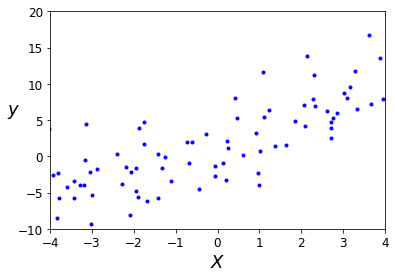

In [2]:
m = 100
X = 10 * np.random.rand(m, 1) - 5
y = 2*X + 2 + 4*np.random.randn(m, 1)
plt.plot(X, y, "b.")
plt.xlabel("$X$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-4, 4, -10, 20])

First write a program to calculate the least squares solution using Algebra, 
$${\bf m= (X^T X)^{-1} X^T y}$$
You can derivate the equation above by taking the first derivative of the MSE(X,y) and making it equal to 0

In [3]:
X_b = np.c_[np.ones((100,1)),X] # add x0 = 1 to each instance
print(X.shape,X_b.shape,X_b.T.shape)

(100, 1) (100, 2) (2, 100)


We can see the shape of X extended by selecting the first 10 samples.

In [4]:
X_b[0:10,:]

array([[ 1.        , -1.25459881],
       [ 1.        ,  4.50714306],
       [ 1.        ,  2.31993942],
       [ 1.        ,  0.98658484],
       [ 1.        , -3.4398136 ],
       [ 1.        , -3.4400548 ],
       [ 1.        , -4.41916388],
       [ 1.        ,  3.66176146],
       [ 1.        ,  1.01115012],
       [ 1.        ,  2.08072578]])

In [5]:
#notice the difference between a filter 
print('filter',X_b[0:10][1])
# and a double index
print('double index',X_b[0:10,1])

filter [1.         4.50714306]
double index [-1.25459881  4.50714306  2.31993942  0.98658484 -3.4398136  -3.4400548
 -4.41916388  3.66176146  1.01115012  2.08072578]


Notice that $X_b=[1 \space X]$ has as many rows as datapoints and as many columns as unknowns.\
The LS solution requires taking the inverse of $X_b^T X_b$ which is small for small number of parameters (even if there are many data points).\
This approach of LS is called the overdetermined solution because it is optimal for overdetermined systems (more unknowns than equations).\
For single threaded run, the cost is proportional to $M^3$, being $M$ the number of parameters. \
This is following the O notation, which does not take into account parallelization.\
In general it may be much less. This is a small cost for small number of parameters but large if we use many features.

In [22]:
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
print(theta_best)

[[1.94083818]
 [1.81609071]]


An easier way to see this is perhaps with the proper matrix multiplication symbol ```@```

In [23]:
theta_bestb = np.linalg.inv(X_b.T@X_b)@X_b.T@y
print(theta_best)

[[1.94083818]
 [1.81609071]]


Inverting a matrix is expensive, proportional to $N^2$ to $N^3$, but depends on the implemtation and CPU power, it maybe faster due to parallelization and cached memory.

In [13]:
# Notice cost of inverting  a matrix for your computer;
nnn=[10,100,1000]
for nn in nnn:
    print('expected',nn**2/nnn[0]**2,' times')
    test=np.random.rand(nn,nn)
    %timeit -n10 np.linalg.inv(test)

expected 1.0  times
The slowest run took 11.79 times longer than the fastest. This could mean that an intermediate result is being cached.
1.06 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)
expected 100.0  times
The slowest run took 24.32 times longer than the fastest. This could mean that an intermediate result is being cached.
27.8 ms ± 29.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
expected 10000.0  times
65.8 ms ± 12.3 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [12]:
#%timeit?

To plot the model we just need to plot two extremes.\
The matrix $X_b$ was calculated with the origiginal coordinates, so we need a new operator $Xnew_b$\
This operator will create the output y when acting on the model parameters.

In [24]:
X_new = np.array([[-4], [4]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[-5.32352466],
       [ 9.20520101]])

(-4.0, 4.0, -10.0, 20.0)

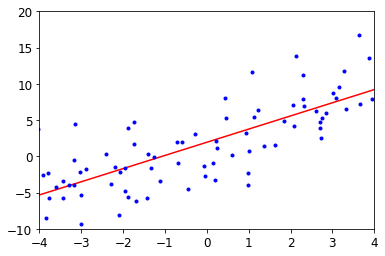

In [25]:
plt.plot(X_new, y_predict, "r-")
plt.plot(X, y, "b.")
plt.axis([-4, 4, -10, 20])

Now let us do the same estimation using gradient descent (GD) also known as steepest descent.\
We minimize the residuals but moving constantly on the negative direction of the gradient, that is following the descent.\
Basically, the gradient descent is just 
$$ \frac{2}{ndata} X_b^T (residual)$$
The residuals is prediction - data which is
$$ X_b \theta - y$$
We chose a step size $\eta$ to keep the solution from bouncing back and forth around the minimum.

In [26]:
niter=50
eta=.1
m=len(X)
print('number of data points is ',m)
theta= np.random.randn(2,1)
X_b = np.c_[np.ones((100,1)),X]
residual0=X_b.dot(theta) - y
residual=residual0
res0=residual0.T.dot(residual0) #initial residual energy
print('initial residual=%d'%res0)
for epoch in range(niter):
    gradients = 2/m* X_b.T.dot(residual)
    theta = theta - eta*gradients
    residual = X_b.dot(theta) - y
    res = residual.T.dot(residual) #residual energy at each iteration
    if (epoch %5 == 0):
        print("epoch -> %d res0=%d res=%d rel=%f"%(epoch,res0,res,res/res0))
    if (res > res0):
        break
    
print("epochs-> %d, res0=%d, res=%d"%(epoch,res0,res))
print(theta.T)

number of data points is  100
initial residual=3670
epoch -> 0 res0=3670 res=2742 rel=0.747079
epoch -> 5 res0=3670 res=1415 rel=0.385613
epoch -> 10 res0=3670 res=1301 rel=0.354620
epoch -> 15 res0=3670 res=1291 rel=0.351871
epoch -> 20 res0=3670 res=1290 rel=0.351618
epoch -> 25 res0=3670 res=1290 rel=0.351594
epoch -> 30 res0=3670 res=1290 rel=0.351592
epoch -> 35 res0=3670 res=1290 rel=0.351591
epoch -> 40 res0=3670 res=1290 rel=0.351591
epoch -> 45 res0=3670 res=1290 rel=0.351591
epochs-> 49, res0=3670, res=1290
[[1.9407953  1.81608567]]


Convergence stops after the first 20 iterations. The data are quite disperse around the main line, so errors are large.\
We can write the whole code in just a few lines (the rest is for monitoring purposes)

In [27]:
eta = 0.1  # learning rate
n_iterations = 50
m = 100

theta = np.random.randn(2,1)  # random initialization

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta) - y)
    theta = theta - eta * gradients
print(theta)
theta_BGD=theta# save for later

[[1.940821 ]
 [1.8160896]]


We can draw the predicted line by taking two points on x and predicting y.
Knowing the model the prediction is simply:
$$ X_b \theta$$

In [40]:
X_new = np.array([[-4], [4]])
X_new_b = np.c_[np.ones((X_new.shape[0], 1)), X_new]  # add x0 = 1 to each instance
y_predict_sd = X_new_b.dot(theta)

(-4.0, 4.0, -10.0, 20.0)

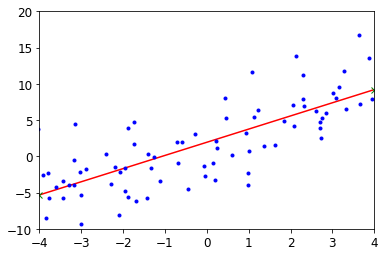

In [41]:
plt.plot(X_new, y_predict_sd, "r-")
plt.plot(X_new, y_predict_sd, "gx")
plt.plot(X, y, "b.")
plt.axis([-4, 4, -10, 20])

Question, what differences would you see if using ```np.arange(-4,4,0.1)``` instead of 2 points?

We can use sklearn to calculate the same. 

In [42]:
from sklearn.linear_model import SGDRegressor
sgd=SGDRegressor(max_iter=50,tol=1e-5,penalty=None,eta0=0.1, random_state=42)
sgd.fit(X,y.ravel())


SGDRegressor(eta0=0.1, max_iter=50, penalty=None, random_state=42, tol=1e-05)

In [43]:
print(sgd.intercept_,sgd.coef_)

[2.22601729] [1.74842699]


In [44]:
y_predictSL = sgd.predict(X_new)

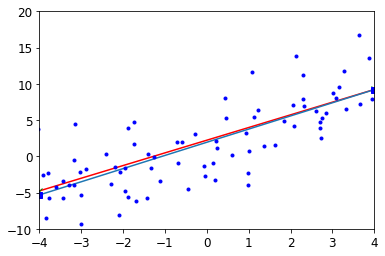

In [45]:
plt.plot(X_new, y_predictSL, "r-")
plt.plot(X_new, y_predictSL, "gx")
plt.plot(X_new, y_predict_sd, "o-")
plt.plot(X_new, y_predict_sd, "bs")

plt.plot(X, y, "b.")
plt.axis([-4, 4, -10, 20])
plt.show()

There is a small difference on the parameters, perhaps due to different initialization or tolerance. 

GD requires to calculate predictions on each iteration. The cost of calculating predictions is dependent on the number of data points.\
Then the GD algorithm can become expensive for large data sets. 
However, if we think about relativelly well behaved data we can assume that the gradient calculated on each point will be more or less on the right direction. Therefore we can calculate the gradient for each point (very quickly) independently and just follow that direction. This is called Stochastic GD

In [46]:
eta = 0.1  # learning rate
n_epochs = 50
m = len(X)
t0, t1=50,50
def step(t):
    return float(t0)/(t+t1)
theta = np.random.randn(2,1)  # random initialization

for epoch in range(n_epochs):
    for i in range(m):
        ri = np.random.randint(m) # take one sample randomly and calculate the model 
        xi = X_b[ri:ri+1]
        yi = y[ri:ri+1]        
        gradients = 2/m * xi.T.dot(xi.dot(theta) - yi)
        eta=step(epoch*m + i) # variable step size, increasing with iterations.
        if (epoch%50==0)&(i%100==0): print("eta=",eta)
        theta = theta - eta * gradients
print(theta)
theta_SGD=theta

eta= 1.0
[[1.83176347]
 [1.85305108]]


Or we can do something in between, defining a  minibatch (random subset of samples).

In [48]:
n_epochs = 500
minibatch=20
t0, t1=5,10
def step(t):
    return t0/(t+t1)
theta = np.random.randn(2,1)  # random initialization
t=0
m=len(X_b)
print(m)
print(np.random.permutation(m))
for epoch in range(n_epochs):
    shuffled=np.random.permutation(m)
    
    X_b_sh = X_b[shuffled]
    y_sh = y[shuffled]
    for i in range(0,m,minibatch):
        t+=1        
        xi = X_b_sh[i:i+minibatch]
        yi = y_sh[i:i+minibatch]        
        gradients = 2/minibatch * xi.T.dot(xi.dot(theta) - yi)
        eta=0.01 #step(t)
        #if (i%10==0): print(eta)
        theta = theta - eta * gradients
print(theta)
theta_MBGD=theta

100
[11  9 51  5 33 53 66 68 83 10 37  4 52 89 50 24 88 60 69 38 43 45 42 76
 55  2 32  6 87 95 22 99 39 20 67 63 40 93 46 26 44 78  8 34 29 82 21 94
 56 91 85  0 57 16 84  1 35 27 86 65 70 31 98 72 36 47 92 90 97 48 75 96
 81 13 58 15 30 14 64 17 19 23 18 79 59 77 80 54 62 41 12 49 73  3 61  7
 28 74 25 71]
[[1.94495263]
 [1.81315013]]


let us plot the three cases

In [49]:
X_new = np.array([[-4], [4]])
X_new_b = np.c_[np.ones((2, 1)), X_new]  # add x0 = 1 to each instance
y_predict_BGD = X_new_b.dot(theta_BGD)
y_predict_SGD = X_new_b.dot(theta_SGD)
y_predict_MBGD = X_new_b.dot(theta_MBGD)

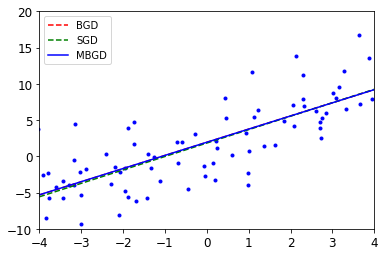

In [50]:
plt.plot(X, y, "b.")
plt.plot(X_new, y_predict_BGD, "r--",label='BGD')
plt.plot(X_new, y_predict_SGD, "g--",label='SGD')
plt.plot(X_new, y_predict_MBGD, "b-",label='MBGD')
plt.legend()
plt.axis([-4, 4, -10, 20])
plt.show()

Practice: create a function to do the 3 methods BGD, SGD and MBGD

## PART 2: Polynomial Regression with sklearn
Fit the data set below with polynomial models of degrees 3, 7 and 11 and choose the one with the best MSE

1) Use sklearn, first in two steps then with a pipeline. First use polynomial features to calculate the powers for the original features and combinations. Second use the fit method usign LinearRegression. Do first the degree=3 step by step and then generalize the procedure in a loop with a pipeline. 

2) Plot train and validation errors for linear regression models using linear and polynomial features.

3) Add Ridge and Lasso regularization to prevent overfitting

Question: how is it possible that we use a Linear model (LinearRegression) to a non-linear model (high powers of X)?



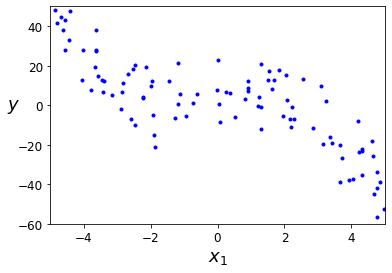

In [51]:
m = 100 #number of data points
X = 10 * np.random.rand(m, 1) - 5
y = - 0.5 * X**3 + 0.1*X**2 + 2*X + 2 + 10*np.random.randn(m, 1)

plt.plot(X, y, "b.")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.axis([-5, 5, -60, 50])
plt.show()


###  Part 2.1 - Try 3rd degree first
Question: what is the code below doing when calling fit_transform?

In [52]:
from sklearn.preprocessing import PolynomialFeatures
poly_features = PolynomialFeatures(degree=3, include_bias=True)
X_poly = poly_features.fit_transform(X)
print(X_poly.shape)
print(X[0])
print(X_poly[0])


(100, 4)
[-3.62532095]
[  1.          -3.62532095  13.14295197 -47.6474191 ]


In [53]:
print(np.power(X[0],2),np.power(X[0],3))

[13.14295197] [-47.6474191]


In statistics, the coefficient of determination, denoted R2 or r2 and pronounced "R squared", is the proportion of the variation in the dependent variable that is predictable from the independent variable(s).

In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
lin_reg = LinearRegression()
lin_reg.fit(X_poly, y)
print('intercept=',lin_reg.intercept_, '--- coefficients=', lin_reg.coef_)
y_pred=lin_reg.predict(X_poly);
# The mean squared error
print('Mean squared error: %.2f'%mean_squared_error(y, y_pred))
# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'%r2_score(y, y_pred))

intercept= [3.04664488] --- coefficients= [[ 0.          2.03799254  0.01459613 -0.51431646]]
Mean squared error: 118.93
Coefficient of determination: 0.80


Let us plot the model

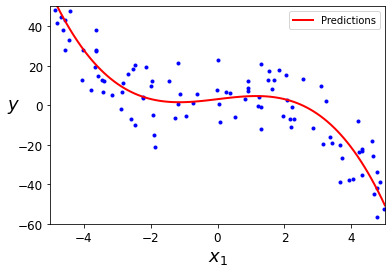

In [57]:
X_new=np.linspace(-5, 5, 100).reshape(100, 1)
X_new_poly = poly_features.transform(X_new)
y_new = lin_reg.predict(X_new_poly)
plt.plot(X, y, "b.")
plt.plot(X_new, y_new, "r-", linewidth=2, label="Predictions")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
plt.legend()
plt.axis([-5, 5, -60, 50])
plt.show()

Write a simple pipeline with degree 3 using a pipeline. Exercise: compare with the result adding the standardscaler.

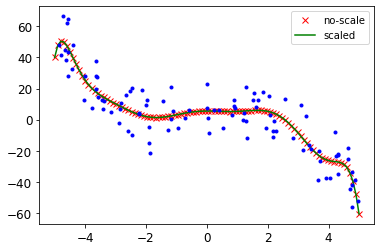

In [58]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
polynomial_regression=Pipeline([
    ("poly_features",PolynomialFeatures(degree=11, include_bias=True)),
    ("linear_reg",LinearRegression())
])

polynomial_regression.fit(X,y)
y_pred= polynomial_regression.predict(X_new)

polynomial_regression_scale=Pipeline([
    ("poly_features",PolynomialFeatures(degree=11, include_bias=True)),
    ("scaling",StandardScaler()),
    ("linear_reg",LinearRegression())
])

polynomial_regression_scale.fit(X,y)
y_pred_scale= polynomial_regression_scale.predict(X_new)


plt.plot(X_new, y_pred,'rx',label="no-scale")
plt.plot(X_new, y_pred_scale,'g-',label="scaled")
plt.plot(X,y,'b.')
plt.legend()

Here is a more sophisticated version from Geron's book that calculates several pipelines in a loop

Mean squared error for degree=3: 118.93
Mean squared error for degree=7: 114.12
Mean squared error for degree=11: 108.50


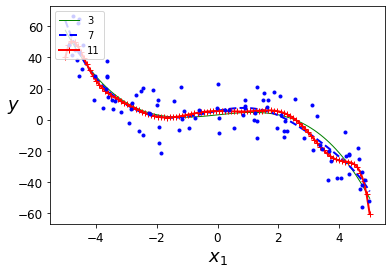

In [59]:
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

for style, width, degree in (("g-", 1, 3), ("b--", 2, 7), ("r-+", 2, 11)):
    polybig_features = PolynomialFeatures(degree=degree, include_bias=False)
    std_scaler = StandardScaler()
    lin_reg = LinearRegression()
    polynomial_regression = Pipeline([
            ("poly_features", polybig_features),
            ("std_scaler", std_scaler),
            ("lin_reg", lin_reg),
        ])
    polynomial_regression.fit(X, y)
    y_pred = polynomial_regression.predict(X)
    print('Mean squared error for degree=%d: %.2f'%(degree,mean_squared_error(y, y_pred)))
    y_newbig = polynomial_regression.predict(X_new)
    
    plt.plot(X_new, y_newbig, style, label=str(degree), linewidth=width)

plt.plot(X, y, "b.", linewidth=3)
plt.legend(loc="upper left")
plt.xlabel("$x_1$", fontsize=18)
plt.ylabel("$y$", rotation=0, fontsize=18)
#plt.axis([-3, 3, 0, 10])
plt.show()

### Part 2.2 - Training and validation curves
Let us plot how the error changes with iterations. Below is a function from Geron's book that stores errors for both \
training and validation sets as the training progresses. This is not very efficient since a new model is fit for each sample \
but it is just to show how errors change as you add more sample points.

In [60]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=10)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train[:m], y_train_predict))
        val_errors.append(mean_squared_error(y_val, y_val_predict))

    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.legend(loc="upper right", fontsize=14)   # not shown in the book
    plt.xlabel("Training set size", fontsize=14) # not shown
    plt.ylabel("RMSE", fontsize=14)              # not shown

Using this function, we can plot the errors for any of the models we did before (just change the model name).\
For example, for linear regressor:


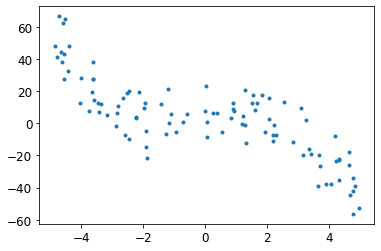

In [61]:
plt.plot(X,y,'.')

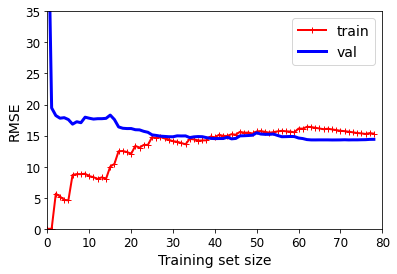

In [62]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)
plt.axis([0, 80, 0, 35])                         
plt.show()  

The training and validation curves have large errors and do not change when increasing the training data, indicating that the model is too simple.
Let us do the same for a polynomial features model with maximum degree equal 3

(0.0, 80.0, 0.0, 35.0)

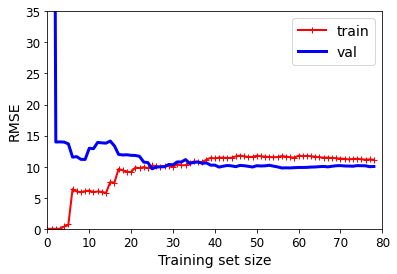

In [65]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=3, include_bias=False)),
        ("stdscaler",StandardScaler()),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 35])           

Now, the two curves reach a smaller error indicating the model is better than before.
We could keep increasing complexity but we will need regularization. For example with degree=11

(0.0, 80.0, 0.0, 35.0)

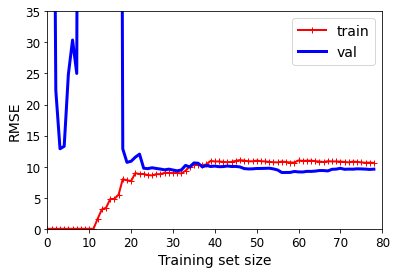

In [66]:
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline([
        ("poly_features", PolynomialFeatures(degree=11, include_bias=False)),
        ("stdscaler",StandardScaler()),
        ("lin_reg", LinearRegression()),
    ])

plot_learning_curves(polynomial_regression, X, y)
plt.axis([0, 80, 0, 35])           

Here the model is complex enough but there is overfitting since the validation has much more error than training until enough samples are available.\
Also there is a gap indicating training does much better than validation. This indicates poor generalization. 

### Part 2.3: Ridge and Lasso
Replace LinearRegression with Ridge or Lasso. 
Basically it is the same as before but instead of calling LinearRegression we call either Ridge \
or Lasso classes, which are generalized versions of data misfit least squares fitting problems with the addition of $\ell_2$ or $\ell_1$ regularization functions. \
You can use the alpha parameter to increase regularization. 

In [67]:
from sklearn.linear_model import Ridge, Lasso
#initialize classes for Ridge, Lasso and features.
ridge_reg = Ridge(alpha=10000.00,max_iter=1000,tol=.001)
lasso_reg = Lasso(alpha=10000,max_iter=1000,tol=.001)
poly = PolynomialFeatures(degree=11, include_bias=False)
# use the classes to generate the features and then fit them using l2 or l1
X_poly = poly.fit_transform(X)
X_new_poly = poly.transform(X_new)
print(ridge_reg.fit(X_poly,y))
print(lasso_reg.fit(X_poly,y))

Ridge(alpha=10000.0, max_iter=1000)
Lasso(alpha=10000, tol=0.001)


/home/dtrad/anaconda3/envs/tfgpu4/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:647: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.889e+02, tolerance: 5.960e+01
  model = cd_fast.enet_coordinate_descent(


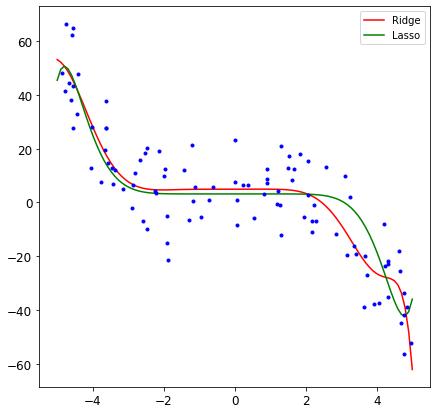

In [68]:
# With the calculated models we can predict the y values for a sample X axis 
y_new_r=ridge_reg.predict(X_new_poly)
y_new_l=lasso_reg.predict(X_new_poly)
plt.figure(figsize=(7,7))
plt.plot(X_new,y_new_r,'r-',label='Ridge')
plt.plot(X_new,y_new_l,'g-',label='Lasso')
plt.plot(X,y,'b.')
plt.legend();

Another way to regularize is to stop training early. For example:

In [69]:
np.random.seed(42)
m = 100
X = 6 * np.random.rand(m, 1) - 3
y = 2 + X + 0.5 * X**2 + np.random.randn(m, 1)
X_train, X_val, y_train, y_val = train_test_split(X[:50], y[:50].ravel(), test_size=0.5, random_state=10)

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
401
(25, 1) (25, 1)


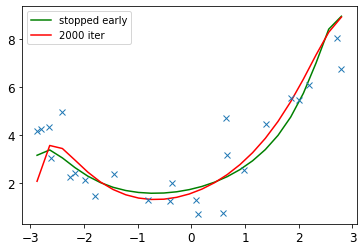

In [70]:
from sklearn.base import clone
from copy import deepcopy
poly_scaler = Pipeline([
        ("poly_features", PolynomialFeatures(degree=21, include_bias=False)),
        ("std_scaler", StandardScaler())
    ])

X_train_poly_scaled = poly_scaler.fit_transform(X_train)
X_val_poly_scaled = poly_scaler.transform(X_val)

sgd_reg = SGDRegressor(max_iter=1, tol=-np.infty, warm_start=True,
                       penalty=None, learning_rate="constant", eta0=0.0005, random_state=42)

minimum_val_error = float("inf")
best_epoch = None
best_model = None
for epoch in range(2000):
    sgd_reg.fit(X_train_poly_scaled, y_train)  # continues where it left off
    y_val_predict = sgd_reg.predict(X_val_poly_scaled)
    val_error = mean_squared_error(y_val, y_val_predict)
    if val_error < minimum_val_error:
        #print('iter=',epoch,'REACHED MINIMUM ERROR',val_error)
        minimum_val_error = val_error
        best_epoch = epoch
        best_model = deepcopy(sgd_reg)
    if (epoch%100==0): print(epoch)
print(best_epoch)

X_new0=np.linspace(np.min(X_val),np.max(X_val),25)
X_new=X_new0[:, np.newaxis]
print(X_new.shape,X_val.shape)
X_new_poly_scaled=poly_scaler.transform(X_new)       
y_val_predict_best = best_model.predict(X_new_poly_scaled)
y_val_predict = sgd_reg.predict(X_new_poly_scaled)
plt.plot(X_new,y_val_predict_best,'g-',label='stopped early')
plt.plot(X_new,y_val_predict,'r-',label='2000 iter')
plt.plot(X_val,y_val,'x')
plt.legend();

## Part 3: Logistic Regression
Load the following dataset and use logistic regression to classify as Iris-Virgilica using two different attributes, one the petal width and the other an attribute of your choice. Confirm results are similar in both cases. Finally use both simultaneously.

In [ ]:
from sklearn import datasets
iris = datasets.load_iris()
print(iris.keys())
print(type(iris))

In [ ]:
#print(iris.DESCR)

First we will do the classification independently using binary classifiers. \
We will take the features petal length and petal width to decide if the flower is Iris Virginica (class=2)

In [ ]:
#Let us petal width as in the book and also petal length
X1 = iris["data"][:,2:3] # Petal Length (see description)
X2 = iris["data"][:,3:]  # Petal Width 
print(X1.shape, X2.shape)
print('X1=',X1[0:150].T, '\n X2=',X2[0:150].T)
# convert 3-classes target to binary (False-True) but using numbers 0 - 1
print(iris["target"][0:150])
# Iris Virginica is class 2 (see description)
y= (iris["target"] == 2).astype(np.int)
print(y.shape)
print(y[0:150])

In [ ]:
# Create two classifiers, one using the feature in X1, another using feature in X2
from sklearn.linear_model import LogisticRegression
logreg1= LogisticRegression(solver="lbfgs", random_state=42)
logreg2= LogisticRegression(solver="lbfgs", random_state=42)
logreg1.fit(X1,y)
logreg2.fit(X2,y)

To see the space of probabilities we will define 2 axes spanning the possible values for each feature.
Then we predict the probabilities for each and plot in 2 separate plots.

In [ ]:
# Let create a regular testing X axis for each feature.
X_new1 = np.linspace(1,7,1000).reshape(-1,1)  # add a second axis dimension 1.
X_new2 = np.linspace(0,3,1000).reshape(-1,1)
print(X_new1.shape, X_new2.shape)
# Use the two classifiers modelled in the previous cell for the 2 features.
y_proba1 = logreg1.predict_proba(X_new1)
y_proba2 = logreg2.predict_proba(X_new2)
print("predictions have two columns because there are two classes",y_proba1.shape)
plt.subplot(121);
plt.plot(X_new1, y_proba1[:,1],label='Virginica'),
plt.plot(X_new1, y_proba1[:,0],label='No Virginica'),
plt.xlabel('feature range')
plt.ylabel('probability')
plt.legend(),
plt.title('petal length')
plt.subplot(122);
plt.plot(X_new2, y_proba2[:,1],label='Virginica'),
plt.plot(X_new2, y_proba2[:,0],label='No Virginica'),
plt.xlabel('feature range')
plt.legend()
plt.title('petal width')

If we have a flower with petal length=6 and petal width=2 is it Virginica?

In [ ]:
probability=logreg1.predict_proba(np.array(6).reshape(-1,1))
print(probability)
print(np.argmax(probability))

In [ ]:
probability2=logreg2.predict_proba(np.array(2).reshape(-1,1))
print(probability2)
print(np.argmax(probability2))

Both cases gave us True because the values were outside the region of doubt. 
Where are the decision boundaries for each feature?

In [ ]:
decision_boundary1 = X_new1[y_proba1[:, 1] >= 0.5][0]
print("petal length=",decision_boundary1)
decision_boundary2 = X_new2[y_proba2[:, 1] >= 0.5][0]
print("petal width=",decision_boundary2)


Now let us do the binary classification but using the two features simultaneously.\
All what is required is to input all the features we want to use simultaneously. 

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = (iris["target"] == 2).astype(np.int)

log_reg = LogisticRegression(solver="lbfgs", C=10**10, random_state=42)
log_reg.fit(X, y)
y_proba = log_reg.predict_proba(X)
print("Again, there are two classes so two columns",y_proba.shape)
print("The features matrix now, contains two columns",X.shape)
classes=log_reg.predict(X)
print("\n the predicted probabilities are: \n",y_proba[50:100,0])
print("\n the actual predicted classes are: \n",classes[50:100])

To plot the probability map it is a bit more involved because we need to define a regular grid to plot the surface map.

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(2.9, 7, 500).reshape(-1, 1),
        np.linspace(0.8, 2.7, 200).reshape(-1, 1),
    )
print(x0.shape, x1.shape)
X_new = np.c_[x0.ravel(), x1.ravel()]
y_proba_map = log_reg.predict_proba(X_new)
zz = y_proba_map[:, 1].reshape(x0.shape)

In [ ]:
plt.figure(figsize=(10, 4))
contour = plt.contour(x0, x1, zz, cmap=plt.cm.brg)
plt.plot(X[y==0, 0], X[y==0, 1], "bs", label="No Virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "g^", label="Virginica")
plt.legend()
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.axis([2.9, 7, 0.8, 2.7])

Now let us use both simultaneously. Notice that there are two parameters: number of features (2) and number of classes (3).

In [ ]:
X = iris["data"][:, (2, 3)]  # petal length, petal width
y = iris["target"]
# To enforce the multiclass approach we need to set "multinomial"
softmax_reg = LogisticRegression(multi_class="multinomial",solver="lbfgs", C=10, random_state=42)
softmax_reg.fit(X, y)

In [ ]:
print(y)

In [ ]:
# let us define a simple testing function
def tellclass(classifier, sample):
    probabilities=classifier.predict_proba(sample)
    theclass=classifier.predict(sample) # also can use np.argmax(probabilities)
    probability=probabilities.ravel()[theclass]    
    print('For a sample with length, width=',sample)
    print("The probabilities for classes 0, 1 and 2 are ",np.round(probabilities*100,2))
    print("The class with maximum probability is",theclass)
    print("That has maximum probability %4.2f"% np.round(probability*100,2))
# First, let us see for a sample on the training set
XX=(X.reshape(150,2))

tellclass(softmax_reg,XX[0,np.newaxis])
print("***********\n")
# Let us check for a new sample
sample=np.asarray([[6,2]])
tellclass(softmax_reg,sample)



In [ ]:
print((XX[0,np.newaxis]).shape)
print(sample.shape)

Following the example in the book, here is a 2D plot of the features classifying on the 3 classes.

In [ ]:
x0, x1 = np.meshgrid(
        np.linspace(0, 8, 500).reshape(-1, 1),
        np.linspace(0, 3.5, 200).reshape(-1, 1),
    )
X_new = np.c_[x0.ravel(), x1.ravel()]

y_proba = softmax_reg.predict_proba(X_new)
y_predict = softmax_reg.predict(X_new)

print(X_new.shape, y_proba.shape, y_predict.shape)

zz1 = y_proba[:, 1].reshape(x0.shape)
zz = y_predict.reshape(x0.shape)

plt.figure(figsize=(10, 4))
plt.plot(X[y==2, 0], X[y==2, 1], "g^", label="Iris virginica")
plt.plot(X[y==1, 0], X[y==1, 1], "bs", label="Iris versicolor")
plt.plot(X[y==0, 0], X[y==0, 1], "yo", label="Iris setosa")

from matplotlib.colors import ListedColormap
custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])

plt.contourf(x0, x1, zz, cmap=custom_cmap)
contour = plt.contour(x0, x1, zz1, cmap=plt.cm.brg)
plt.clabel(contour, inline=1, fontsize=12)
plt.xlabel("Petal length", fontsize=14)
plt.ylabel("Petal width", fontsize=14)
plt.legend(loc="center left", fontsize=14)
plt.axis([0, 7, 0, 3.5])
plt.show()